### Import and Download Dependencies

In [1]:
from kaggle_secrets import UserSecretsClient
import requests
import os


import h5py
import nibabel as nib
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
plt.style.use("dark_background")

from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

In [2]:
!pip install timm einops ml_collections wget tensorboardX SimpleITK medpy

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00
  Created wheel for ml_collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94507 sha256=4f2f76684efd39635dd972acf41c7fce4ef9c626a91cc03c71f50e8daf5818c1
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=624e705818d7c8c3c5a0ceb949c3f93f6a2cbd1bd2b7cd397c2bd7ec499e2636
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
  Created wheel for medpy: filename=MedPy-0.5.1-py3-none-any.whl size=224731 sha256=0d983893970ff4763a7a4a

In [3]:
!git clone "https://huggingface.co/Unknown6197/BEFUnet_Brats2020"

Cloning into 'BEFUnet_Brats2020'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 59 (delta 3), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (59/59), 568.63 KiB | 1.04 MiB/s, done.
Filtering content: 100% (3/3), 270.02 MiB | 102.98 MiB/s, done.


In [5]:
#cd /kaggle/working/BEFUnet_Brats2020
import sys
sys.path.insert(1,'/kaggle/working/BEFUnet_Brats2020')

### Handeling Data Brats Trial

In [6]:
from datasets import dataset_synapse

db_train = dataset_synapse.Synapse_dataset(base_dir="/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data",
                                           list_dir="/kaggle/working/BEFUnet_Brats2020/lists",
                                           split="train",
                                           transform=v2.Compose([
                                               dataset_synapse.RandomGenerator(output_size=[224,224])
                                           ]))

db_test = dataset_synapse.Synapse_dataset(base_dir="/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data",
                                           list_dir="/kaggle/working/BEFUnet_Brats2020/lists",
                                           split="test_vol",
                                           transform=v2.Compose([
                                               dataset_synapse.transform_test(output_size=[224,224])
                                           ]))

train_loader = DataLoader(db_train, batch_size=5, shuffle=True)
test_loader = DataLoader(db_test, batch_size=1, shuffle=False)

In [7]:
for sample in train_loader:
    print('Train image shape ' , sample['image'].shape , ', label shape ' , sample['label'].shape, ', Number of Training Batches' , len(db_train)//5)
    break
for sample in test_loader:
    print('test image shape ' , sample['image'].shape , ', label shape ' , sample['label'].shape, ', Number of test Batches' , len(db_test))
    break

Train image shape  torch.Size([5, 1, 224, 224]) , label shape  torch.Size([5, 224, 224]) , Number of Training Batches 10078
test image shape  torch.Size([1, 1, 224, 224]) , label shape  torch.Size([1, 224, 224]) , Number of test Batches 509


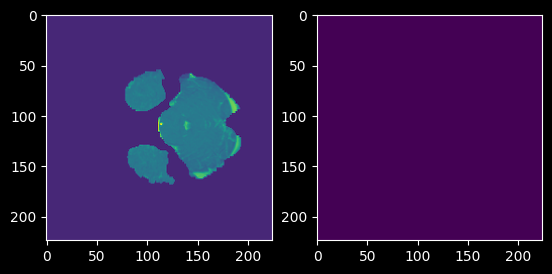

In [8]:
for sample in train_loader:
    img = sample["image"][:]
    mask = sample["label"][:]
    fig,axs = plt.subplots(1,2)
    axs[0].imshow(img[0].squeeze(0))
    axs[1].imshow(mask[0])
    break

### Model

In [14]:
from configs.BEFUnet_configs import get_BEFUnet_configs
from models.BEFUnet import BEFUnet

cfg = get_BEFUnet_configs()
model = BEFUnet(cfg,n_classes=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

{'layer0': 'cd', 'layer1': 'ad', 'layer2': 'rd', 'layer3': 'cv', 'layer4': 'cd', 'layer5': 'ad', 'layer6': 'rd', 'layer7': 'cv', 'layer8': 'cd', 'layer9': 'ad', 'layer10': 'rd', 'layer11': 'cv', 'layer12': 'cd', 'layer13': 'ad', 'layer14': 'rd', 'layer15': 'cv'}
initialization done


BEFUnet(
  (All2Cross): All2Cross(
    (pyramid): PyramidFeatures(
      (swin_transformer): SwinTransformer(
        (pos_drop): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0): BasicLayer(
            dim=96, input_resolution=(56, 56), depth=2
            (blocks): ModuleList(
              (0): SwinTransformerBlock(
                dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
                (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                (attn): WindowAttention(
                  dim=96, window_size=(7, 7), num_heads=3
                  (qkv): Linear(in_features=96, out_features=288, bias=True)
                  (attn_drop): Dropout(p=0.0, inplace=False)
                  (proj): Linear(in_features=96, out_features=96, bias=True)
                  (proj_drop): Dropout(p=0.0, inplace=False)
                  (softmax): Softmax(dim=-1)
                )
                (drop_path): I

In [15]:
from utils import DiceLoss
epochs = 10
lr = 0.001
dice_loss = DiceLoss(3)
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr,weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [16]:
def train_model(model,train_loader,epochs,lr,device):
    model.train()
    for epoch in range(epochs):
        running_loss = 0
        print(f"epoch {epoch+1}",end=' ')
        for batch in tqdm(train_loader):
            image_batch, label_batch = batch['image'], batch['label']
            image_batch, label_batch = image_batch.to(device), label_batch.to(device)

            B, C, H, W = image_batch.shape
            image_batch = image_batch.expand(B, 3, H, W)
            
            outputs = model(image_batch)
            
            loss_ce = ce_loss(outputs, label_batch[:].long())
            loss_dice = dice_loss(outputs, label_batch, softmax=True)
            loss = 0.4 * loss_ce + 0.6 * loss_dice
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()  
            running_loss += loss.item()
            
        scheduler.step()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
        torch.save(model.state_dict(), f'/kaggle/working/model_weights{epoch+1}.pth')
        print("Weights Saving done!")
        torch.save(scheduler.state_dict(), f'/kaggle/working/scheduler_epoch_{epoch+1}.pth')
        print("Scheduler Saved")

In [23]:
train_model(model,train_loader,epochs,lr,device)

epoch 1 

  0%|          | 0/838 [00:00<?, ?it/s]

Epoch 1, Loss: 0.08561455703347139
Weights Saving done!
Scheduler Saved
epoch 2 

  0%|          | 0/838 [00:00<?, ?it/s]

Epoch 2, Loss: 0.07932216909253939
Weights Saving done!
Scheduler Saved
epoch 3 

  0%|          | 0/838 [00:00<?, ?it/s]

Epoch 3, Loss: 0.07809048690577537
Weights Saving done!
Scheduler Saved
epoch 4 

  0%|          | 0/838 [00:00<?, ?it/s]

Epoch 4, Loss: 0.07286411665628946
Weights Saving done!
Scheduler Saved
epoch 5 

  0%|          | 0/838 [00:00<?, ?it/s]

Epoch 5, Loss: 0.07244663434392086
Weights Saving done!
Scheduler Saved
epoch 6 

  0%|          | 0/838 [00:00<?, ?it/s]

Epoch 6, Loss: 0.07254846055429598
Weights Saving done!
Scheduler Saved
epoch 7 

  0%|          | 0/838 [00:00<?, ?it/s]

Epoch 7, Loss: 0.06905580954159429
Weights Saving done!
Scheduler Saved
epoch 8 

  0%|          | 0/838 [00:00<?, ?it/s]

Epoch 8, Loss: 0.06761107241528148
Weights Saving done!
Scheduler Saved
epoch 9 

  0%|          | 0/838 [00:00<?, ?it/s]

Epoch 9, Loss: 0.06636053835750871
Weights Saving done!
Scheduler Saved
epoch 10 

  0%|          | 0/838 [00:00<?, ?it/s]

Epoch 10, Loss: 0.06797028024323054
Weights Saving done!
Scheduler Saved


In [17]:
# Load the weights into a dictionary
weights_path = '/kaggle/working/BEFUnet_Brats2020/weights/model_weights_brats_9_Adam.pth'
weights_dict = torch.load(weights_path, map_location=torch.device(device))
# Load the weights into your model
model.load_state_dict(weights_dict)

<All keys matched successfully>

In [20]:
def calculate_miou(mask, seg_pred):
    
    mask = mask.detach().numpy()
    
    seg_pred = seg_pred.detach().numpy()
    seg_pred = seg_pred.squeeze(0)
    
    intersection = np.logical_and(mask, seg_pred)
    union = np.logical_or(mask, seg_pred)

    # Calculate IoU
    if np.sum(union) == 0:
        return 1 if np.sum(intersection) == 0 else 0
    else:
        # Calculate IoU
        iou = np.sum(intersection) / np.sum(union)
        return iou

def calculate_dice_loss(mask, seg_pred):
    mask = mask.detach().numpy()

    seg_pred = seg_pred.detach().numpy()
    seg_pred = seg_pred.squeeze(0)

    # Calculate Intersection
    intersection = np.sum(mask * seg_pred)

    # Calculate Dice loss
    dice_loss = 1 - ((2. * intersection + 1e-6) / (np.sum(mask) + np.sum(seg_pred) + 1e-6))

    return dice_loss

Print 10 test samples


  0%|          | 0/509 [00:00<?, ?it/s]

Batch 1


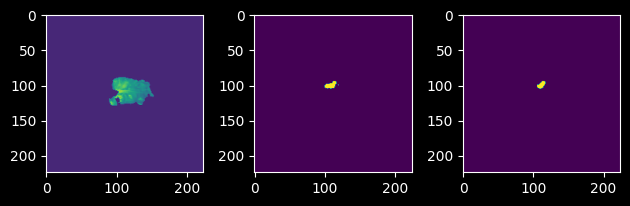

Batch 2


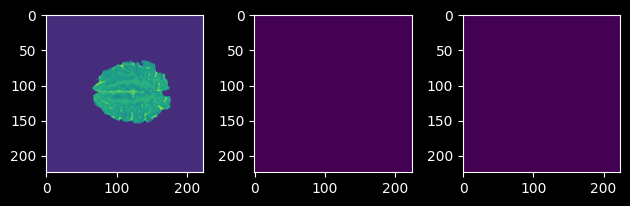

Batch 3


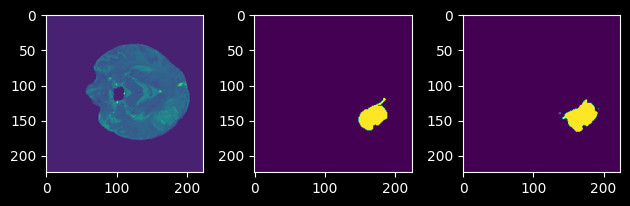

Batch 4


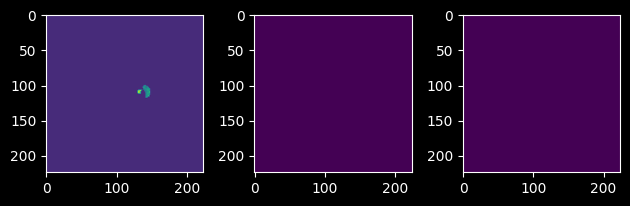

Batch 5


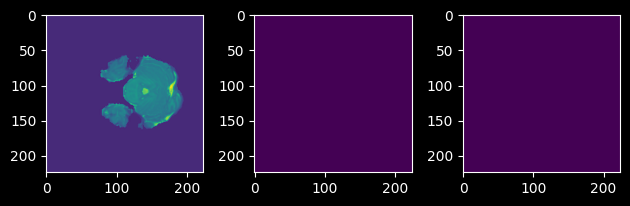

Batch 6


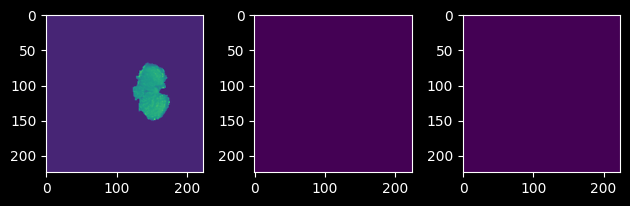

Batch 7


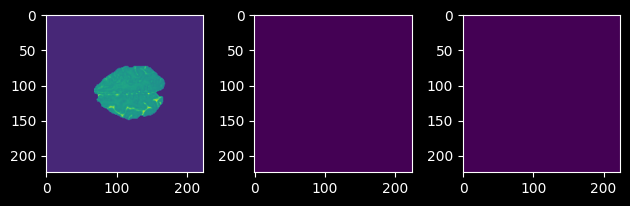

Batch 8


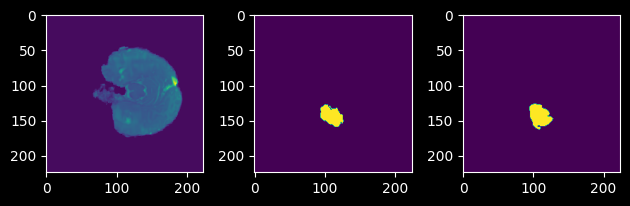

Batch 9


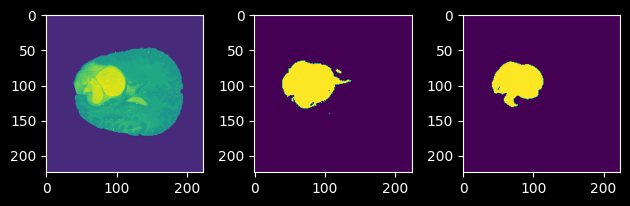

Batch 10


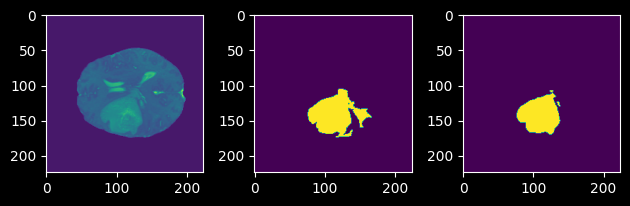

Total Avg_MIoU : 0.8051742487800382
Total Avg_dice_coef : 0.15425151207497362


In [21]:
model.eval()
model.to('cpu')
count = 0

avg_miou = []
avg_dice_coef = []

print("Print 10 test samples")
for sample in tqdm(test_loader):
    img, label = sample['image'], sample['label']
    
    image_batch, label_batch = img.to('cpu'), label.to('cpu')

    B, C, H, W = image_batch.shape
    image_batch = image_batch.expand(B, 3, H, W)
    
    outputs = model(image_batch)
    outputs = torch.argmax(torch.softmax(outputs, dim=1), dim=1, keepdim=True)

    avg_miou.append(calculate_miou(label_batch,outputs))
    avg_dice_coef.append(calculate_dice_loss(label_batch,outputs))
       
    
 
    if count < 10:
        print(f'Batch {count+1}')
        fig,axs = plt.subplots(1,3)
        axs[0].imshow(img[0].permute(1,2,0))
        axs[1].imshow(label[0].squeeze(0))
        axs[2].imshow(outputs[0].squeeze(0))
        plt.tight_layout()
        plt.show()
    else:
        continue   
        
    count+= 1
    
print(f'Total Avg_MIoU : {sum(avg_miou)/len(test_loader)}\nTotal Avg_dice_coef : {sum(avg_dice_coef)/len(test_loader)}')

In [21]:
class predictor_h5(nn.Module):
    def __init__(self,model,output_size):
        super().__init__()
        self.model = model.eval()
        self.output_size = output_size
        
    def forward(self,x):
        img, label = x['image'][:], x['mask'][:]

        image, label = np.max(img,axis = -1), np.max(label,axis = -1)

        h, w = image.shape

        if h != self.output_size[0] or w != self.output_size[1]:
            image = zoom(image, (self.output_size[0] / h, self.output_size[1] / w), order=3)  # why not 3?
            label = zoom(label, (self.output_size[0] / h, self.output_size[1] / w), order=0)

        image = torch.from_numpy(image.astype(np.float32)).unsqueeze(0)
        label = torch.from_numpy(label.astype(np.float32)).long()


        image = image.expand(1,3,image.shape[1],image.shape[2])

        # forward path for image
        x = self.model(image)
        # give probability to each output class torch.argmax(torch.softmax(outputs, dim=1), dim=1, keepdim=True)
        x = torch.softmax(x,dim=1)
        # choose the class with the highest probability
        x = torch.argmax(x,dim=1,keepdim=True)
        
        return x

In [22]:
path = "/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_100_slice_64.h5"
output_size = (224,224)

data = h5py.File(path)

In [23]:
img, label = data['image'][:], data['mask'][:]

image, label = np.max(img,axis = -1), np.max(label,axis = -1)

h, w = image.shape

if h != output_size[0] or w != output_size[1]:
    image = zoom(image, (output_size[0] / h, output_size[1] / w), order=3)  # why not 3?
    label = zoom(label, (output_size[0] / h, output_size[1] / w), order=0)

image = torch.from_numpy(image.astype(np.float32)).unsqueeze(0)
label = torch.from_numpy(label.astype(np.float32)).long()


image = image.expand(1,3,image.shape[1],image.shape[2])

In [24]:
pred = predictor_h5(model,(224,224))
output = pred.forward(data)

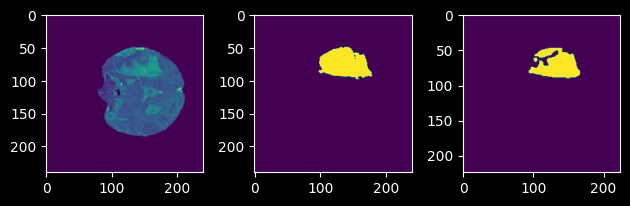

In [25]:
fig,axs = plt.subplots(1,3)
axs[0].imshow(np.max(data['image'][:],-1))
axs[1].imshow(np.max(data['mask'][:],-1))
axs[2].imshow(output[0].squeeze(0))
plt.tight_layout()
plt.show()